### INSTALLATION OF MODULE

In [ ]:
!pip install tensorflow==2.8.0
!pip install keras==2.8.0
!pip install tensorflow-addons==0.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 46.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing 

### **Import Library and datasets**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt


In [ ]:
num_classes=10
input_shape=(32,32,3)

(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()
print(f"x_train shape:{x_train.shape} - y_train shape:{y_train.shape}")
print(f"x_test shape:{x_test.shape} - y_test shape:{y_test.shape}")


170508288/170498071 [==============================] - 2s 0us/step
x_train shape:(50000, 32, 32, 3) - y_train shape:(50000, 1)
x_test shape:(10000, 32, 32, 3) - y_test shape:(10000, 1)


In [ ]:
x_train=x_train[:500]
y_train=y_train[:500]
x_test=x_test[:500]
y_test=y_test[:500]

### HYPER PARAMETER DEFINITION

In [ ]:
learning_rate=0.001
weight_decay=0.0001
batch_size=256
num_epochs=40
image_size=72
patch_size=6
num_patches=(image_size//patch_size)**2
projection_dim=64
num_heads=4
transformer_units=[
    projection_dim*2,
    projection_dim
]
transformer_layers=8
mlp_head_units=[2048,1024]


### BUILD VIT CLASSIFIER

### DATA AUGMENTATION

In [ ]:
data_augmentation=keras.Sequential(
    [
    layers.Normalization(),
    layers.Resizing(image_size,image_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.02),
    layers.RandomZoom(
        height_factor=0.2,width_factor=0.2)
    ],
    name="data_augmentation"
)
data_augmentation.layers[0].adapt(x_train)

### MLP ARCHITECTURE

In [ ]:
def mlp(x,hidden_units,dropout_rate):
  for units in hidden_units:
    x=layers.Dense(units,activation=tf.nn.gelu)(x)
    x=layers.Dropout(dropout_rate)(x)
  return x

### PATCHES

In [ ]:
class Patches(layers.Layer):
  def __init__(self,patch_size):
    super(Patches,self).__init__()
    self.patch_size=patch_size

  def call(self,images):
    batch_size=tf.shape(images)[0]
    patches=tf.image.extract_patches(
        images=images,
        sizes=[1,self.patch_size,self.patch_size,1],
        strides=[1,self.patch_size,self.patch_size,1],
        rates=[1,1,1,1],
        padding="VALID",
    )
    patch_dims=patches.shape[-1]
    patches=tf.reshape(patches,[batch_size,-1,patch_dims])
    return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


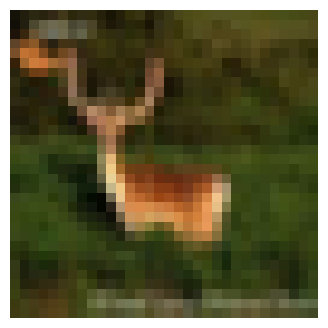

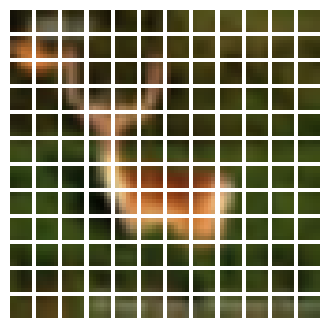

In [ ]:
plt.figure(figsize=(4,4))
image=x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image=tf.image.resize(
    tf.convert_to_tensor([image]),size=(image_size,image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i,patch in enumerate(patches[0]):
  ax=plt.subplot(n,n,i+1)
  patch_img=tf.reshape(patch,(patch_size,patch_size,3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
  def __init__(self,num_patches,projection_dim):
    super(PatchEncoder,self).__init__()
    self.num_patches=num_patches
    self.projection=layers.Dense(units=projection_dim)
    self.position_embedding=layers.Embedding(
        input_dim=num_patches,output_dim=projection_dim
    )
  def call(self,patch):
    positions=tf.range(start=0,limit=self.num_patches,delta=1)
    encoded=self.projection(patch)+self.position_embedding(positions)
    return encoded


In [ ]:
def create_vit_classifier():
  inputs=layers.Input(shape=input_shape)
  augmented= data_augmentation(inputs)
  patches=Patches(patch_size)(augmented)
  encoded_patches=PatchEncoder(num_patches,projection_dim)(patches)
  for _ in range(transformer_layers):
    x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output=layers.MultiHeadAttention(
        num_heads=num_heads,key_dim=projection_dim,dropout=0.1
    )(x1,x1)
    x2=layers.Add()([attention_output,encoded_patches])
    x3=layers.LayerNormalization(epsilon=1e-6)(x2)
    x3=mlp(x3,hidden_units=transformer_units,dropout_rate=0.1)
    encoded_patches=layers.Add()([x3,x2])
  representation=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation=layers.Flatten()(representation)
  representation=layers.Dropout(0.5)(representation)
  features=mlp(representation,hidden_units=mlp_head_units,dropout_rate=0.5)
  logits=layers.Dense(num_classes)(features)
  model=keras.Model(inputs=inputs,outputs=logits)
  return model


In [ ]:
def run_experiment(model):
  optimizer=tfa.optimizers.AdamW(
      learning_rate=learning_rate,weight_decay=weight_decay)
  model.compile(
      optimizer=optimizer,
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5,name="top_5_accuracy"),])
  checkpoint_filepath="./tmp/checkpoint"
  checkpoint_callback=keras.callbacks.ModelCheckpoint(checkpoint_filepath,monitor="val_accuracy",save_best_only=True,save_weights_only=True, )
  history=model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_split=0.1,
      callbacks=[checkpoint_callback],
  )

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy=model.evaluate(x_test,y_test)
  print(f"Test accuracy: {round(accuracy*100,2)}%")
  print(f"Test Top 5 accuracy:{round(top_5_accuracy*100,2)}%")

In [ ]:
vit_classifier=create_vit_classifier()
history=run_experiment(vit_classifier)

Epoch 1/40
2/2 [==============================] - 51s 18s/step - loss: 5.5674 - accuracy: 0.1222 - top_5_accuracy: 0.5911 - val_loss: 4.0679 - val_accuracy: 0.3000 - val_top_5_accuracy: 0.6600
Epoch 2/40
2/2 [==============================] - 31s 13s/step - loss: 5.8669 - accuracy: 0.2156 - top_5_accuracy: 0.5978 - val_loss: 3.0980 - val_accuracy: 0.1600 - val_top_5_accuracy: 0.6600
Epoch 3/40
2/2 [==============================] - 31s 14s/step - loss: 3.7784 - accuracy: 0.2067 - top_5_accuracy: 0.6733 - val_loss: 1.9966 - val_accuracy: 0.2600 - val_top_5_accuracy: 0.8200
Epoch 4/40
2/2 [==============================] - 38s 19s/step - loss: 2.7284 - accuracy: 0.2400 - top_5_accuracy: 0.7489 - val_loss: 1.9587 - val_accuracy: 0.3400 - val_top_5_accuracy: 0.8200
Epoch 5/40
2/2 [==============================] - 38s 15s/step - loss: 2.6797 - accuracy: 0.2667 - top_5_accuracy: 0.7511 - val_loss: 1.9123 - val_accuracy: 0.2600 - val_top_5_accuracy: 0.8400
Epoch 6/40
2/2 [===================

In [ ]:
class_names=[
    'airplane',
    'automobile',
    'bird',
    'deer',
    'cat',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [ ]:
def img_predict(images,model):
  if len(images.shape)==3:
    out=model.predict(images.reshape(-1,*images.shape))
  else:
    out=model.predict(images)
  prediction=np.argmax(out,axis=1)
  img_prediction=[class_names[i]for i in prediction]
  return img_prediction

['automobile']


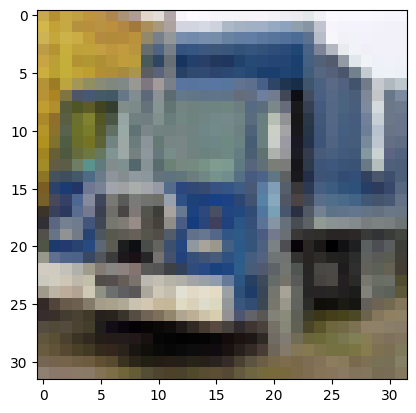

In [ ]:
index=14
plt.imshow(x_test[index])
prediction=img_predict(x_test[index],vit_classifier)
print(prediction)